Code to reproduce running example of

B. Legat, R. M. Jungers, and P. A. Parrilo **An entropy-based bound for the computational complexity of a switched system**. IEEE Transactions on Automatic Control, https://doi.org/10.1109/TAC.2019.2902625

In [2]:
using HybridSystems
include(joinpath(dirname(dirname(pathof(HybridSystems))), "examples", "PEDJ16s4.jl"))
using SwitchOnSafety
_savefig(name) = Plots.savefig("../results/$name.eps");

┌ Info: Recompiling stale cache file /home/blegat/.julia/compiled/v1.1/HybridSystems/omX1S.ji for HybridSystems [2207ec0c-686c-5054-b4d2-543502888820]
└ @ Base loading.jl:1184
┌ Info: Precompiling SwitchOnSafety [ceb7f16a-07bf-5f4a-9354-b68f01b1610f]
└ @ Base loading.jl:1186


In [3]:
using MosekTools
using JuMP
solver = with_optimizer(Mosek.Optimizer, QUIET=true)

┌ Info: Recompiling stale cache file /home/blegat/.julia/compiled/v1.1/MosekTools/UJwlm.ji for MosekTools [1ec41992-ff65-5c91-ac43-2df89e9693a4]
└ @ Base loading.jl:1184


OptimizerFactory(Mosek.Optimizer, (), Base.Iterators.Pairs(:QUIET=>true))

In [6]:
using MultivariateMoments
using LightGraphs
using LinearAlgebra

function prune_lyap(d, solver; tol=3e-7, threshold=2e-4)
    if length(sosdata(hs).lyaps) ≥ d
        sosdata(hs).lyaps[d] = nothing
    end
    soslb, sosub = soslyapb(hs, d, factory=solver, tol=tol)
    G = copy(hs.automaton.G)
    dual = getlyap(hs, d).dual
    μs = map(t -> norm(dual[t].Q.Q, Inf), transitions(hs))
    maxμs = maximum(μs)
    min_kept = Inf
    max_left = 0.0
    @show sort(μs / maxμs)
    for (i, t) in enumerate(transitions(hs))
        x = μs[i] / maxμs
        if x < threshold
            max_left = max(max_left, x)
            rem_edge!(G, t.edge)
        else
            min_kept = min(min_kept, x)
        end
    end
    println(max_left, " < ", threshold, " < ", min_kept)
    return soslb, sosub, ρ(adjacency_matrix(G))
end

prune_lyap (generic function with 1 method)

In [7]:
sosb = prune_lyap.(1:6, Ref(solver))

sort(μs / maxμs) = [3.82951e-7, 4.89884e-7, 6.50315e-7, 6.62128e-7, 8.16912e-7, 8.43434e-7, 0.644312, 0.942364, 1.0]
8.43434135755067e-7 < 0.0002 < 0.6443119643325338
sort(μs / maxμs) = [6.38436e-7, 8.13757e-7, 9.72646e-7, 1.32941e-6, 1.9136e-6, 2.74022e-6, 0.176517, 0.42859, 1.0]
2.740218466337836e-6 < 0.0002 < 0.1765168798324311
sort(μs / maxμs) = [1.03015e-6, 1.19841e-6, 1.42536e-6, 4.18464e-6, 0.0601089, 0.110974, 0.120978, 0.24618, 1.0]
4.184640701603601e-6 < 0.0002 < 0.06010887320090561
sort(μs / maxμs) = [2.58109e-7, 7.85543e-7, 1.02583e-6, 1.0358e-6, 0.0331839, 0.228945, 0.390375, 0.494206, 1.0]
1.0357991468345856e-6 < 0.0002 < 0.03318390522289925
sort(μs / maxμs) = [1.57022e-6, 1.72952e-6, 2.17106e-6, 2.17575e-6, 0.0164789, 0.161922, 0.305794, 0.412272, 1.0]
2.175745402566825e-6 < 0.0002 < 0.01647893732896833
sort(μs / maxμs) = [1.11441e-6, 3.2938e-6, 3.64918e-6, 5.23258e-6, 0.00836874, 0.127531, 0.222401, 0.334751, 1.0]
5.232584323885028e-6 < 0.0002 < 0.008368742251479206


6-element Array{Tuple{Float64,Float64,Float64},1}:
 (0.7096199402330368, 1.0035543230574266, 1.618033988749895)
 (0.7753990260138268, 0.9863230324613662, 1.618033988749895)
 (0.8321070828192696, 0.9768814637887235, 1.83928675521416) 
 (0.8644570590955903, 0.974968172813975, 1.83928675521416)  
 (0.8854899009453173, 0.9749474883660003, 1.83928675521416) 
 (0.8997628268765168, 0.9748985479159743, 1.83928675521416) 

We can compute several different lower bounds from the upper bound found using Sum-of-Squares.

In [8]:
soslb = map(x -> x[1], sosb)
sosub = map(x -> x[2], sosb)
ρG = ρ(adjacency_matrix(hs.automaton.G))
@show ρG
bi(d) = binomial(2+d-1,d)
m = HybridSystems.ntransitions(hs)
@show m
# Theorem 2
soslbρ = map(x -> x[2][2]/(ρG^(1/(2x[1]))), enumerate(sosb))
# Theorem 3
soslbn = map(x -> x[2][2]/(bi(x[1])^(1/(2x[1]))), enumerate(sosb))
# Theorem 4
sosllb = map(x -> x[2][2]/(x[2][3]^(1/(2x[1]))), enumerate(sosb))
# Kronecker lift
soslbm = map(x -> x[2][2]/(m^(1/(2x[1]))), enumerate(sosb))
bi.(1:6)

ρG = 2.618033988749896
m = 9


6-element Array{Int64,1}:
 2
 3
 4
 5
 6
 7

In [23]:
sosprl = zeros(6)
sospru = zeros(6)
# sospru = sosprl .* (SwitchOnSafety.ρA(hs) .^ (1 ./ (2:2:12)))
for i in 1:6
    @time sosprl[i], sospru[i] = pradiusb(hs, 2*i, VeroneseLift())
end

  0.008467 seconds (1.40 k allocations: 133.781 KiB)
  0.000592 seconds (2.46 k allocations: 230.672 KiB)
  0.000815 seconds (4.14 k allocations: 391.250 KiB)
  0.001178 seconds (6.43 k allocations: 621.203 KiB)
  0.001856 seconds (9.43 k allocations: 932.344 KiB)
  0.002796 seconds (13.15 k allocations: 1.294 MiB)


In [24]:
[soslb'; sosub'; soslbρ'; soslbn'; sosllb'; soslbm'; sosprl'; sospru']

8×6 Array{Float64,2}:
 0.70962   0.775399  0.832107  0.864457  0.88549   0.899763
 1.00355   0.986323  0.976881  0.974968  0.974947  0.974899
 0.620231  0.775399  0.832107  0.864457  0.88549   0.899763
 0.70962   0.749443  0.775351  0.797295  0.815016  0.828962
 0.788946  0.874525  0.882538  0.903461  0.91731   0.926628
 0.334518  0.569454  0.677332  0.740816  0.782631  0.811782
 0.879075  0.893726  0.904888  0.913522  0.920342  0.925834
 1.42237   1.13684   1.06233   1.0303    1.01332   1.00315 

Values computed with Mosek:

| d      | 1        | 2        | 3        | 4        | 5        | 6        |
|:------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|
| soslb  | 0.70962  | 0.775399 | 0.832107 | 0.864457 | 0.88549  | 0.899763 |
| sosub  | 1.00355  | 0.986323 | 0.976881 | 0.974968 | 0.974948 | 0.974901 |
| soslbρ | 0.620231 | 0.775399 | 0.832107 | 0.864457 | 0.88549  | 0.899765 |
| soslbn | 0.70962  | 0.749443 | 0.775351 | 0.797295 | 0.815016 | 0.828964 |
| sosllb | 0.788946 | 0.874525 | 0.882538 | 0.903461 | 0.91731  | 0.92663  |
| soslbm | 0.334518 | 0.569454 | 0.677332 | 0.740815 | 0.782631 | 0.811783 |
| sosprl | 0.879075 | 0.893726 | 0.904888 | 0.913522 | 0.920342 | 0.925834 |
| sospru | 1.422373 | 1.136836 | 1.062325 | 1.030305 | 1.013320 | 1.003147 |

Computing the $2d$-radius would be a lot slower with Kronecker lifts than with Veronese lifts.

In [71]:
i = 6
@time sosprl[i], sospru[i] = pradiusb(hs, 2*i, KroneckerLift())

 10.127331 seconds (1.52 k allocations: 1.918 GiB, 5.91% gc time)


(0.9258342753832846, 1.003146883295951)

In [25]:
using Plots
pyplot()

┌ Info: Recompiling stale cache file /home/blegat/.julia/compiled/v1.1/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/blegat/.julia/compiled/v1.1/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1184


Plots.PyPlotBackend()


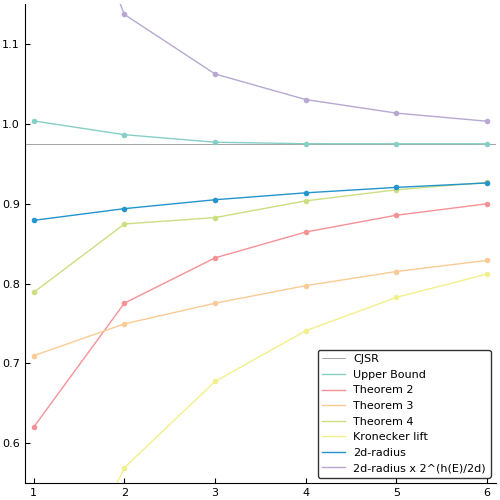

In [98]:
xlims = (0.9, 6.1)
plot(size=(500, 500), xlims=xlims, ylims=(0.55, 1.15), legend=:bottomright, grid=false)
jsr = 0.9748171979372074
plot!(collect(xlims), [jsr, jsr], color=:grey, linewidth=.5, label="CJSR")
# colors taken from https://previews.123rf.com/images/capacitorphoto/capacitorphoto1410/capacitorphoto141000191/32438941-Graph-Icon-color-set-illustration--Stock-Vector.jpg
red = Plots.RGBA(((0xf5, 0x92, 0x97) ./ 255)...)
gre = Plots.RGBA(((0xcb, 0xdf, 0x80) ./ 255)...)
blu = Plots.RGBA(((0x23, 0x94, 0xce) ./ 255)...)
ora = Plots.RGBA(((0xfa, 0xcb, 0x95) ./ 255)...)
yel = Plots.RGBA(((0xf2, 0xf0, 0x8b) ./ 255)...)
pur = Plots.RGBA(((0xb7, 0xa8, 0xd1) ./ 255)...)
eme = Plots.RGBA(((0x86, 0xcf, 0xc6) ./ 255)...)
function _plot!(bound, col, name)
    plot!(1:6, bound, label=name, color=col)
    scatter!(1:6, bound, label="", markerstrokewidth=0, color=col)
end
_plot!(sosub, eme, "Upper Bound")
_plot!(soslbρ, red, "Theorem 2")
_plot!(soslbn, ora, "Theorem 3")
_plot!(sosllb, gre, "Theorem 4")
_plot!(soslbm, yel, "Kronecker lift")
_plot!(sosprl, blu, "2d-radius")
_plot!(sospru, pur, "2d-radius x 2^(h(E)/2d)")